# Convolutional Neural Network

This example shows how to design a simple CNN.

We also show the impact of quantization on accuracy and lastly how to run the model in FHE.

### Import required modules

In [1]:
import time

import numpy as np
import torch
import torch.utils
from concrete.compiler import check_gpu_available
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

# And some helpers for visualization.

%matplotlib inline

import matplotlib.pyplot as plt

### Load the data-set and visualize it

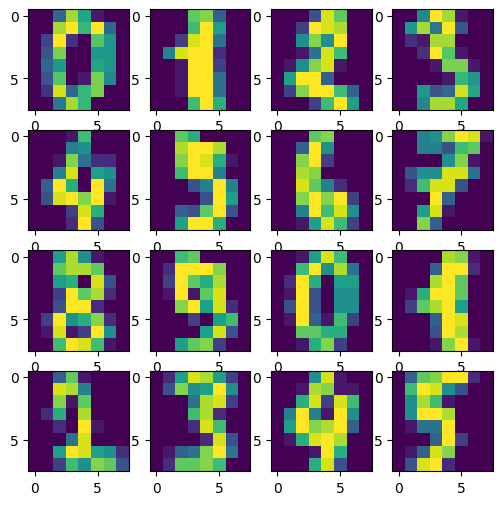

In [2]:
X, y = load_digits(return_X_y=True)

# The sklearn Digits data-set, though it contains digit images, keeps these images in vectors
# so we need to reshape them to 2D first. The images are 8x8 px in size and monochrome
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

nplot = 4
fig, ax = plt.subplots(nplot, nplot, figsize=(6, 6))
for i in range(0, nplot):
    for j in range(0, nplot):
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())
plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

### Define the neural network

In [3]:
class TinyCNN(nn.Module):
    """A very small CNN to classify the sklearn digits data-set."""

    def __init__(self, n_classes) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        # This network has a total complexity of 1216 MAC
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, 2, stride=1, padding=0)
        self.fc1 = nn.Linear(32, n_classes)

    def forward(self, x):
        """Run inference on the tiny CNN, apply the decision layer on the reshaped conv output."""
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

### Train the CNN

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   1%|▏         | 2/150 [00:00<00:13, 10.91it/s]

Training:   3%|▎         | 4/150 [00:00<00:12, 11.23it/s]

Training:   4%|▍         | 6/150 [00:00<00:12, 11.38it/s]

Training:   5%|▌         | 8/150 [00:00<00:12, 11.64it/s]

Training:   7%|▋         | 10/150 [00:00<00:11, 11.79it/s]

Training:   8%|▊         | 12/150 [00:01<00:11, 11.89it/s]

Training:   9%|▉         | 14/150 [00:01<00:11, 11.97it/s]

Training:  11%|█         | 16/150 [00:01<00:11, 12.01it/s]

Training:  12%|█▏        | 18/150 [00:01<00:10, 12.05it/s]

Training:  13%|█▎        | 20/150 [00:01<00:10, 12.06it/s]

Training:  15%|█▍        | 22/150 [00:01<00:10, 12.10it/s]

Training:  16%|█▌        | 24/150 [00:02<00:10, 12.11it/s]

Training:  17%|█▋        | 26/150 [00:02<00:10, 12.14it/s]

Training:  19%|█▊        | 28/150 [00:02<00:10, 12.17it/s]

Training:  20%|██        | 30/150 [00:02<00:09, 12.19it/s]

Training:  21%|██▏       | 32/150 [00:02<00:09, 12.19it/s]

Training:  23%|██▎       | 34/150 [00:02<00:09, 12.19it/s]

Training:  24%|██▍       | 36/150 [00:02<00:09, 12.19it/s]

Training:  25%|██▌       | 38/150 [00:03<00:09, 12.18it/s]

Training:  27%|██▋       | 40/150 [00:03<00:09, 12.17it/s]

Training:  28%|██▊       | 42/150 [00:03<00:08, 12.17it/s]

Training:  29%|██▉       | 44/150 [00:03<00:08, 12.17it/s]

Training:  31%|███       | 46/150 [00:03<00:08, 12.16it/s]

Training:  32%|███▏      | 48/150 [00:03<00:08, 12.17it/s]

Training:  33%|███▎      | 50/150 [00:04<00:08, 12.18it/s]

Training:  35%|███▍      | 52/150 [00:04<00:08, 12.19it/s]

Training:  36%|███▌      | 54/150 [00:04<00:07, 12.19it/s]

Training:  37%|███▋      | 56/150 [00:04<00:07, 12.19it/s]

Training:  39%|███▊      | 58/150 [00:04<00:07, 12.19it/s]

Training:  40%|████      | 60/150 [00:04<00:07, 12.19it/s]

Training:  41%|████▏     | 62/150 [00:05<00:07, 12.19it/s]

Training:  43%|████▎     | 64/150 [00:05<00:07, 12.20it/s]

Training:  44%|████▍     | 66/150 [00:05<00:06, 12.20it/s]

Training:  45%|████▌     | 68/150 [00:05<00:06, 12.21it/s]

Training:  47%|████▋     | 70/150 [00:05<00:06, 12.20it/s]

Training:  48%|████▊     | 72/150 [00:05<00:06, 12.21it/s]

Training:  49%|████▉     | 74/150 [00:06<00:06, 12.22it/s]

Training:  51%|█████     | 76/150 [00:06<00:06, 12.23it/s]

Training:  52%|█████▏    | 78/150 [00:06<00:05, 12.24it/s]

Training:  53%|█████▎    | 80/150 [00:06<00:05, 12.25it/s]

Training:  55%|█████▍    | 82/150 [00:06<00:05, 12.25it/s]

Training:  56%|█████▌    | 84/150 [00:06<00:05, 12.25it/s]

Training:  57%|█████▋    | 86/150 [00:07<00:05, 12.26it/s]

Training:  59%|█████▊    | 88/150 [00:07<00:05, 12.26it/s]

Training:  60%|██████    | 90/150 [00:07<00:04, 12.25it/s]

Training:  61%|██████▏   | 92/150 [00:07<00:04, 12.25it/s]

Training:  63%|██████▎   | 94/150 [00:07<00:04, 12.23it/s]

Training:  64%|██████▍   | 96/150 [00:07<00:04, 12.03it/s]

Training:  65%|██████▌   | 98/150 [00:08<00:04, 12.08it/s]

Training:  67%|██████▋   | 100/150 [00:08<00:04, 12.11it/s]

Training:  68%|██████▊   | 102/150 [00:08<00:03, 12.12it/s]

Training:  69%|██████▉   | 104/150 [00:08<00:03, 12.14it/s]

Training:  71%|███████   | 106/150 [00:08<00:03, 12.15it/s]

Training:  72%|███████▏  | 108/150 [00:08<00:03, 12.15it/s]

Training:  73%|███████▎  | 110/150 [00:09<00:03, 12.17it/s]

Training:  75%|███████▍  | 112/150 [00:09<00:03, 12.17it/s]

Training:  76%|███████▌  | 114/150 [00:09<00:02, 12.16it/s]

Training:  77%|███████▋  | 116/150 [00:09<00:02, 12.15it/s]

Training:  79%|███████▊  | 118/150 [00:09<00:02, 12.15it/s]

Training:  80%|████████  | 120/150 [00:09<00:02, 12.15it/s]

Training:  81%|████████▏ | 122/150 [00:10<00:02, 12.16it/s]

Training:  83%|████████▎ | 124/150 [00:10<00:02, 12.16it/s]

Training:  84%|████████▍ | 126/150 [00:10<00:01, 12.16it/s]

Training:  85%|████████▌ | 128/150 [00:10<00:01, 12.16it/s]

Training:  87%|████████▋ | 130/150 [00:10<00:01, 12.15it/s]

Training:  88%|████████▊ | 132/150 [00:10<00:01, 12.15it/s]

Training:  89%|████████▉ | 134/150 [00:11<00:01, 12.15it/s]

Training:  91%|█████████ | 136/150 [00:11<00:01, 12.15it/s]

Training:  92%|█████████▏| 138/150 [00:11<00:00, 12.16it/s]

Training:  93%|█████████▎| 140/150 [00:11<00:00, 12.17it/s]

Training:  95%|█████████▍| 142/150 [00:11<00:00, 12.17it/s]

Training:  96%|█████████▌| 144/150 [00:11<00:00, 12.17it/s]

Training:  97%|█████████▋| 146/150 [00:12<00:00, 12.18it/s]

Training:  99%|█████████▊| 148/150 [00:12<00:00, 12.17it/s]

Training: 100%|██████████| 150/150 [00:12<00:00, 12.17it/s]

Training: 100%|██████████| 150/150 [00:12<00:00, 12.13it/s]

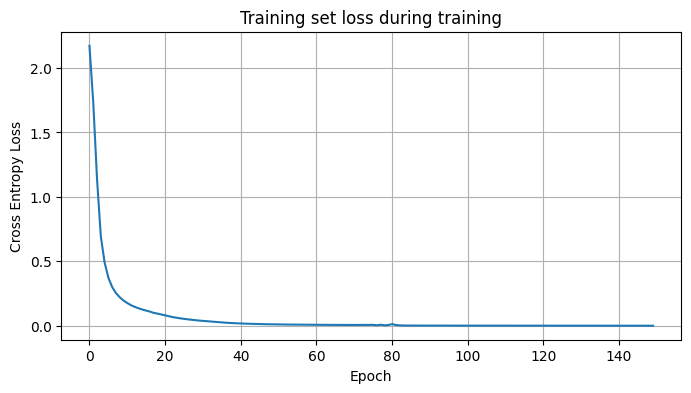

In [4]:
torch.manual_seed(42)


def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)


# Create the tiny CNN with 10 output classes
N_EPOCHS = 150

# Create a train data loader
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

# Create a test data loader to supply batches for network evaluation (test)
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset)

# Train the network with Adam, output the test set accuracy every epoch
net = TinyCNN(10)
losses_bits = []
optimizer = torch.optim.Adam(net.parameters())
for _ in tqdm(range(N_EPOCHS), desc="Training"):
    losses_bits.append(train_one_epoch(net, optimizer, train_dataloader))

fig = plt.figure(figsize=(8, 4))
plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

### Test the torch network in fp32

In [5]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy for fp32 weights and activations: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


test_torch(net, test_dataloader)

Test accuracy for fp32 weights and activations: 98.22%


### Define the Concrete ML testing function

We introduce the `test_with_concrete` function which allows us to test a Concrete ML model in one of two modes:
- in FHE
- in the clear, using simulated FHE execution

Note that it is trivial to toggle between between the two modes. 

In [6]:
def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        # Accumulate the ground truth labels
        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)

### Test the network using Simulation

Note that this is not a test in FHE. The simulated FHE mode gives 
insight about the impact of FHE execution on the accuracy.

The torch neural network is converted to FHE by Concrete ML using a dedicated function, `compile_torch_model`.

In [7]:
n_bits = 6

use_gpu_if_available = False
device = "cuda" if use_gpu_if_available and check_gpu_available() else "cpu"

q_module = compile_torch_model(net, x_train, rounding_threshold_bits=6, p_error=0.1, device=device)

start_time = time.time()
accs = test_with_concrete(
    q_module,
    test_dataloader,
    use_sim=True,
)
sim_time = time.time() - start_time

print(f"Simulated FHE execution for {n_bits} bit network accuracy: {accs:.2f}%")

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 1/450 [00:00<04:31,  1.66it/s]

  0%|          | 2/450 [00:00<02:22,  3.14it/s]

  1%|          | 4/450 [00:00<01:12,  6.12it/s]

  1%|▏         | 6/450 [00:00<00:51,  8.70it/s]

  2%|▏         | 8/450 [00:01<00:42, 10.46it/s]

  2%|▏         | 10/450 [00:01<00:36, 12.06it/s]

  3%|▎         | 12/450 [00:01<00:32, 13.29it/s]

  3%|▎         | 14/450 [00:01<00:30, 14.19it/s]

  4%|▎         | 16/450 [00:01<00:29, 14.85it/s]

  4%|▍         | 18/450 [00:01<00:28, 15.26it/s]

  4%|▍         | 20/450 [00:01<00:28, 15.27it/s]

  5%|▍         | 22/450 [00:01<00:27, 15.59it/s]

  5%|▌         | 24/450 [00:02<00:26, 15.85it/s]

  6%|▌         | 26/450 [00:02<00:26, 16.01it/s]

  6%|▌         | 28/450 [00:02<00:26, 16.15it/s]

  7%|▋         | 30/450 [00:02<00:25, 16.25it/s]

  7%|▋         | 32/450 [00:02<00:25, 16.32it/s]

  8%|▊         | 34/450 [00:02<00:25, 16.37it/s]

  8%|▊         | 36/450 [00:02<00:25, 16.41it/s]

  8%|▊         | 38/450 [00:02<00:25, 16.44it/s]

  9%|▉         | 40/450 [00:03<00:24, 16.44it/s]

  9%|▉         | 42/450 [00:03<00:24, 16.45it/s]

 10%|▉         | 44/450 [00:03<00:24, 16.46it/s]

 10%|█         | 46/450 [00:03<00:24, 16.48it/s]

 11%|█         | 48/450 [00:03<00:24, 16.48it/s]

 11%|█         | 50/450 [00:03<00:24, 16.49it/s]

 12%|█▏        | 52/450 [00:03<00:24, 16.49it/s]

 12%|█▏        | 54/450 [00:03<00:24, 16.48it/s]

 12%|█▏        | 56/450 [00:04<00:23, 16.46it/s]

 13%|█▎        | 58/450 [00:04<00:23, 16.46it/s]

 13%|█▎        | 60/450 [00:04<00:23, 16.47it/s]

 14%|█▍        | 62/450 [00:04<00:23, 16.47it/s]

 14%|█▍        | 64/450 [00:04<00:23, 16.47it/s]

 15%|█▍        | 66/450 [00:04<00:23, 16.48it/s]

 15%|█▌        | 68/450 [00:04<00:23, 16.45it/s]

 16%|█▌        | 70/450 [00:04<00:23, 16.09it/s]

 16%|█▌        | 72/450 [00:05<00:23, 16.17it/s]

 16%|█▋        | 74/450 [00:05<00:23, 16.26it/s]

 17%|█▋        | 76/450 [00:05<00:22, 16.32it/s]

 17%|█▋        | 78/450 [00:05<00:22, 16.35it/s]

 18%|█▊        | 80/450 [00:05<00:22, 16.39it/s]

 18%|█▊        | 82/450 [00:05<00:22, 16.41it/s]

 19%|█▊        | 84/450 [00:05<00:22, 16.43it/s]

 19%|█▉        | 86/450 [00:05<00:22, 16.45it/s]

 20%|█▉        | 88/450 [00:05<00:21, 16.46it/s]

 20%|██        | 90/450 [00:06<00:21, 16.46it/s]

 20%|██        | 92/450 [00:06<00:21, 16.47it/s]

 21%|██        | 94/450 [00:06<00:21, 16.48it/s]

 21%|██▏       | 96/450 [00:06<00:21, 16.49it/s]

 22%|██▏       | 98/450 [00:06<00:21, 16.49it/s]

 22%|██▏       | 100/450 [00:06<00:21, 16.49it/s]

 23%|██▎       | 102/450 [00:06<00:21, 16.49it/s]

 23%|██▎       | 104/450 [00:06<00:20, 16.49it/s]

 24%|██▎       | 106/450 [00:07<00:20, 16.48it/s]

 24%|██▍       | 108/450 [00:07<00:20, 16.49it/s]

 24%|██▍       | 110/450 [00:07<00:20, 16.49it/s]

 25%|██▍       | 112/450 [00:07<00:20, 16.50it/s]

 25%|██▌       | 114/450 [00:07<00:20, 16.50it/s]

 26%|██▌       | 116/450 [00:07<00:20, 16.50it/s]

 26%|██▌       | 118/450 [00:07<00:20, 16.49it/s]

 27%|██▋       | 120/450 [00:07<00:20, 16.15it/s]

 27%|██▋       | 122/450 [00:08<00:20, 16.24it/s]

 28%|██▊       | 124/450 [00:08<00:19, 16.31it/s]

 28%|██▊       | 126/450 [00:08<00:19, 16.36it/s]

 28%|██▊       | 128/450 [00:08<00:19, 16.37it/s]

 29%|██▉       | 130/450 [00:08<00:19, 16.34it/s]

 29%|██▉       | 132/450 [00:08<00:19, 16.37it/s]

 30%|██▉       | 134/450 [00:08<00:19, 16.40it/s]

 30%|███       | 136/450 [00:08<00:19, 16.38it/s]

 31%|███       | 138/450 [00:09<00:19, 16.36it/s]

 31%|███       | 140/450 [00:09<00:18, 16.33it/s]

 32%|███▏      | 142/450 [00:09<00:18, 16.33it/s]

 32%|███▏      | 144/450 [00:09<00:18, 16.37it/s]

 32%|███▏      | 146/450 [00:09<00:18, 16.38it/s]

 33%|███▎      | 148/450 [00:09<00:18, 16.35it/s]

 33%|███▎      | 150/450 [00:09<00:18, 16.38it/s]

 34%|███▍      | 152/450 [00:09<00:18, 16.42it/s]

 34%|███▍      | 154/450 [00:10<00:18, 16.35it/s]

 35%|███▍      | 156/450 [00:10<00:17, 16.36it/s]

 35%|███▌      | 158/450 [00:10<00:17, 16.36it/s]

 36%|███▌      | 160/450 [00:10<00:17, 16.35it/s]

 36%|███▌      | 162/450 [00:10<00:17, 16.38it/s]

 36%|███▋      | 164/450 [00:10<00:17, 16.41it/s]

 37%|███▋      | 166/450 [00:10<00:17, 16.40it/s]

 37%|███▋      | 168/450 [00:10<00:17, 16.42it/s]

 38%|███▊      | 170/450 [00:10<00:17, 16.43it/s]

 38%|███▊      | 172/450 [00:11<00:16, 16.45it/s]

 39%|███▊      | 174/450 [00:11<00:16, 16.46it/s]

 39%|███▉      | 176/450 [00:11<00:16, 16.47it/s]

 40%|███▉      | 178/450 [00:11<00:16, 16.49it/s]

 40%|████      | 180/450 [00:11<00:16, 16.50it/s]

 40%|████      | 182/450 [00:11<00:16, 16.50it/s]

 41%|████      | 184/450 [00:11<00:16, 16.50it/s]

 41%|████▏     | 186/450 [00:11<00:16, 16.50it/s]

 42%|████▏     | 188/450 [00:12<00:15, 16.50it/s]

 42%|████▏     | 190/450 [00:12<00:15, 16.50it/s]

 43%|████▎     | 192/450 [00:12<00:15, 16.47it/s]

 43%|████▎     | 194/450 [00:12<00:15, 16.48it/s]

 44%|████▎     | 196/450 [00:12<00:15, 16.49it/s]

 44%|████▍     | 198/450 [00:12<00:15, 16.45it/s]

 44%|████▍     | 200/450 [00:12<00:15, 16.41it/s]

 45%|████▍     | 202/450 [00:12<00:15, 16.40it/s]

 45%|████▌     | 204/450 [00:13<00:14, 16.41it/s]

 46%|████▌     | 206/450 [00:13<00:14, 16.44it/s]

 46%|████▌     | 208/450 [00:13<00:14, 16.45it/s]

 47%|████▋     | 210/450 [00:13<00:14, 16.47it/s]

 47%|████▋     | 212/450 [00:13<00:14, 16.48it/s]

 48%|████▊     | 214/450 [00:13<00:14, 16.50it/s]

 48%|████▊     | 216/450 [00:13<00:14, 16.51it/s]

 48%|████▊     | 218/450 [00:13<00:14, 16.51it/s]

 49%|████▉     | 220/450 [00:14<00:14, 16.26it/s]

 49%|████▉     | 222/450 [00:14<00:14, 16.28it/s]

 50%|████▉     | 224/450 [00:14<00:13, 16.34it/s]

 50%|█████     | 226/450 [00:14<00:13, 16.39it/s]

 51%|█████     | 228/450 [00:14<00:13, 16.39it/s]

 51%|█████     | 230/450 [00:14<00:13, 16.34it/s]

 52%|█████▏    | 232/450 [00:14<00:13, 16.36it/s]

 52%|█████▏    | 234/450 [00:14<00:13, 16.39it/s]

 52%|█████▏    | 236/450 [00:15<00:13, 16.34it/s]

 53%|█████▎    | 238/450 [00:15<00:12, 16.36it/s]

 53%|█████▎    | 240/450 [00:15<00:12, 16.40it/s]

 54%|█████▍    | 242/450 [00:15<00:12, 16.40it/s]

 54%|█████▍    | 244/450 [00:15<00:12, 16.36it/s]

 55%|█████▍    | 246/450 [00:15<00:12, 16.37it/s]

 55%|█████▌    | 248/450 [00:15<00:12, 16.39it/s]

 56%|█████▌    | 250/450 [00:15<00:12, 16.35it/s]

 56%|█████▌    | 252/450 [00:15<00:12, 16.36it/s]

 56%|█████▋    | 254/450 [00:16<00:12, 15.85it/s]

 57%|█████▋    | 256/450 [00:16<00:12, 16.02it/s]

 57%|█████▋    | 258/450 [00:16<00:11, 16.11it/s]

 58%|█████▊    | 260/450 [00:16<00:11, 16.18it/s]

 58%|█████▊    | 262/450 [00:16<00:11, 16.26it/s]

 59%|█████▊    | 264/450 [00:16<00:11, 16.31it/s]

 59%|█████▉    | 266/450 [00:16<00:11, 16.31it/s]

 60%|█████▉    | 268/450 [00:16<00:11, 16.33it/s]

 60%|██████    | 270/450 [00:17<00:10, 16.39it/s]

 60%|██████    | 272/450 [00:17<00:10, 16.37it/s]

 61%|██████    | 274/450 [00:17<00:10, 16.35it/s]

 61%|██████▏   | 276/450 [00:17<00:10, 16.38it/s]

 62%|██████▏   | 278/450 [00:17<00:10, 16.42it/s]

 62%|██████▏   | 280/450 [00:17<00:10, 16.38it/s]

 63%|██████▎   | 282/450 [00:17<00:10, 16.37it/s]

 63%|██████▎   | 284/450 [00:17<00:10, 16.40it/s]

 64%|██████▎   | 286/450 [00:18<00:10, 16.36it/s]

 64%|██████▍   | 288/450 [00:18<00:09, 16.33it/s]

 64%|██████▍   | 290/450 [00:18<00:09, 16.35it/s]

 65%|██████▍   | 292/450 [00:18<00:09, 16.37it/s]

 65%|██████▌   | 294/450 [00:18<00:09, 16.33it/s]

 66%|██████▌   | 296/450 [00:18<00:09, 16.36it/s]

 66%|██████▌   | 298/450 [00:18<00:09, 16.39it/s]

 67%|██████▋   | 300/450 [00:18<00:09, 16.41it/s]

 67%|██████▋   | 302/450 [00:19<00:09, 16.41it/s]

 68%|██████▊   | 304/450 [00:19<00:08, 16.43it/s]

 68%|██████▊   | 306/450 [00:19<00:08, 16.43it/s]

 68%|██████▊   | 308/450 [00:19<00:08, 16.45it/s]

 69%|██████▉   | 310/450 [00:19<00:08, 16.46it/s]

 69%|██████▉   | 312/450 [00:19<00:08, 16.47it/s]

 70%|██████▉   | 314/450 [00:19<00:08, 16.47it/s]

 70%|███████   | 316/450 [00:19<00:08, 16.47it/s]

 71%|███████   | 318/450 [00:20<00:08, 16.44it/s]

 71%|███████   | 320/450 [00:20<00:07, 16.45it/s]

 72%|███████▏  | 322/450 [00:20<00:07, 16.43it/s]

 72%|███████▏  | 324/450 [00:20<00:08, 15.23it/s]

 72%|███████▏  | 326/450 [00:20<00:07, 15.55it/s]

 73%|███████▎  | 328/450 [00:20<00:07, 15.78it/s]

 73%|███████▎  | 330/450 [00:20<00:07, 15.90it/s]

 74%|███████▍  | 332/450 [00:20<00:07, 16.02it/s]

 74%|███████▍  | 334/450 [00:21<00:07, 16.11it/s]

 75%|███████▍  | 336/450 [00:21<00:07, 16.15it/s]

 75%|███████▌  | 338/450 [00:21<00:06, 16.17it/s]

 76%|███████▌  | 340/450 [00:21<00:06, 16.24it/s]

 76%|███████▌  | 342/450 [00:21<00:06, 16.27it/s]

 76%|███████▋  | 344/450 [00:21<00:06, 16.28it/s]

 77%|███████▋  | 346/450 [00:21<00:06, 16.33it/s]

 77%|███████▋  | 348/450 [00:21<00:06, 16.38it/s]

 78%|███████▊  | 350/450 [00:22<00:06, 16.39it/s]

 78%|███████▊  | 352/450 [00:22<00:06, 15.84it/s]

 79%|███████▊  | 354/450 [00:22<00:05, 16.03it/s]

 79%|███████▉  | 356/450 [00:22<00:05, 16.10it/s]

 80%|███████▉  | 358/450 [00:22<00:05, 16.16it/s]

 80%|████████  | 360/450 [00:22<00:05, 16.24it/s]

 80%|████████  | 362/450 [00:22<00:05, 16.31it/s]

 81%|████████  | 364/450 [00:22<00:05, 16.32it/s]

 81%|████████▏ | 366/450 [00:23<00:05, 16.34it/s]

 82%|████████▏ | 368/450 [00:23<00:05, 16.35it/s]

 82%|████████▏ | 370/450 [00:23<00:04, 16.35it/s]

 83%|████████▎ | 372/450 [00:23<00:04, 16.38it/s]

 83%|████████▎ | 374/450 [00:23<00:04, 16.42it/s]

 84%|████████▎ | 376/450 [00:23<00:04, 16.44it/s]

 84%|████████▍ | 378/450 [00:23<00:04, 16.47it/s]

 84%|████████▍ | 380/450 [00:23<00:04, 16.48it/s]

 85%|████████▍ | 382/450 [00:23<00:04, 16.48it/s]

 85%|████████▌ | 384/450 [00:24<00:04, 16.49it/s]

 86%|████████▌ | 386/450 [00:24<00:03, 16.50it/s]

 86%|████████▌ | 388/450 [00:24<00:03, 16.49it/s]

 87%|████████▋ | 390/450 [00:24<00:03, 16.45it/s]

 87%|████████▋ | 392/450 [00:24<00:03, 16.44it/s]

 88%|████████▊ | 394/450 [00:24<00:03, 16.46it/s]

 88%|████████▊ | 396/450 [00:24<00:03, 16.43it/s]

 88%|████████▊ | 398/450 [00:24<00:03, 16.37it/s]

 89%|████████▉ | 400/450 [00:25<00:03, 16.36it/s]

 89%|████████▉ | 402/450 [00:25<00:02, 16.38it/s]

 90%|████████▉ | 404/450 [00:25<00:02, 16.36it/s]

 90%|█████████ | 406/450 [00:25<00:02, 16.37it/s]

 91%|█████████ | 408/450 [00:25<00:02, 16.40it/s]

 91%|█████████ | 410/450 [00:25<00:02, 16.37it/s]

 92%|█████████▏| 412/450 [00:25<00:02, 16.38it/s]

 92%|█████████▏| 414/450 [00:25<00:02, 16.39it/s]

 92%|█████████▏| 416/450 [00:26<00:02, 16.34it/s]

 93%|█████████▎| 418/450 [00:26<00:01, 16.36it/s]

 93%|█████████▎| 420/450 [00:26<00:01, 16.40it/s]

 94%|█████████▍| 422/450 [00:26<00:01, 16.37it/s]

 94%|█████████▍| 424/450 [00:26<00:01, 16.36it/s]

 95%|█████████▍| 426/450 [00:26<00:01, 16.39it/s]

 95%|█████████▌| 428/450 [00:26<00:01, 16.41it/s]

 96%|█████████▌| 430/450 [00:26<00:01, 16.38it/s]

 96%|█████████▌| 432/450 [00:27<00:01, 16.39it/s]

 96%|█████████▋| 434/450 [00:27<00:00, 16.41it/s]

 97%|█████████▋| 436/450 [00:27<00:00, 15.82it/s]

 97%|█████████▋| 438/450 [00:27<00:00, 16.00it/s]

 98%|█████████▊| 440/450 [00:27<00:00, 16.15it/s]

 98%|█████████▊| 442/450 [00:27<00:00, 16.21it/s]

 99%|█████████▊| 444/450 [00:27<00:00, 16.25it/s]

 99%|█████████▉| 446/450 [00:27<00:00, 16.32it/s]

100%|█████████▉| 448/450 [00:28<00:00, 16.35it/s]

100%|██████████| 450/450 [00:28<00:00, 16.29it/s]

100%|██████████| 450/450 [00:28<00:00, 15.99it/s]

Simulated FHE execution for 6 bit network accuracy: 0.97%


### Generate Keys

In [8]:
# Generate keys first
t = time.time()
q_module.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")

Keygen time: 5.04s


### 3. Execute in FHE on encrypted data

In [9]:
# Run inference in FHE on a single encrypted example
mini_test_dataset = TensorDataset(torch.Tensor(x_test[:100, :]), torch.Tensor(y_test[:100]))
mini_test_dataloader = DataLoader(mini_test_dataset)

t = time.time()
accuracy_test = test_with_concrete(
    q_module,
    mini_test_dataloader,
    use_sim=False,
)
elapsed_time = time.time() - t
time_per_inference = elapsed_time / len(mini_test_dataset)
accuracy_percentage = 100 * accuracy_test

print(
    f"Time per inference in FHE: {time_per_inference:.2f} "
    f"with {accuracy_percentage:.2f}% accuracy"
)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:36<1:00:41, 36.78s/it]

  2%|▏         | 2/100 [01:12<58:40, 35.92s/it]  

  3%|▎         | 3/100 [01:47<57:33, 35.60s/it]

  4%|▍         | 4/100 [02:22<56:42, 35.44s/it]

  5%|▌         | 5/100 [02:57<56:03, 35.40s/it]

  6%|▌         | 6/100 [03:33<55:27, 35.40s/it]

  7%|▋         | 7/100 [04:08<54:51, 35.40s/it]

  8%|▊         | 8/100 [04:43<54:03, 35.26s/it]

  9%|▉         | 9/100 [05:18<53:29, 35.27s/it]

 10%|█         | 10/100 [05:54<52:56, 35.30s/it]

 11%|█         | 11/100 [06:29<52:23, 35.32s/it]

 12%|█▏        | 12/100 [07:05<51:50, 35.35s/it]

 13%|█▎        | 13/100 [07:40<51:14, 35.33s/it]

 14%|█▍        | 14/100 [08:15<50:37, 35.32s/it]

 15%|█▌        | 15/100 [08:51<50:04, 35.34s/it]

 16%|█▌        | 16/100 [09:26<49:22, 35.27s/it]

 17%|█▋        | 17/100 [10:01<48:45, 35.25s/it]

 18%|█▊        | 18/100 [10:37<48:23, 35.41s/it]

 19%|█▉        | 19/100 [11:12<47:43, 35.36s/it]

 20%|██        | 20/100 [11:47<47:04, 35.30s/it]

 21%|██        | 21/100 [12:22<46:28, 35.30s/it]

 22%|██▏       | 22/100 [12:57<45:50, 35.26s/it]

 23%|██▎       | 23/100 [13:33<45:11, 35.21s/it]

 24%|██▍       | 24/100 [14:08<44:35, 35.21s/it]

 25%|██▌       | 25/100 [14:43<43:59, 35.19s/it]

 26%|██▌       | 26/100 [15:18<43:25, 35.21s/it]

 27%|██▋       | 27/100 [15:54<42:52, 35.25s/it]

 28%|██▊       | 28/100 [16:29<42:17, 35.25s/it]

 29%|██▉       | 29/100 [17:04<41:41, 35.23s/it]

 30%|███       | 30/100 [17:39<41:06, 35.24s/it]

 31%|███       | 31/100 [18:15<40:33, 35.26s/it]

 32%|███▏      | 32/100 [18:50<39:54, 35.21s/it]

 33%|███▎      | 33/100 [19:25<39:18, 35.20s/it]

 34%|███▍      | 34/100 [20:00<38:43, 35.21s/it]

 35%|███▌      | 35/100 [20:35<38:07, 35.19s/it]

 36%|███▌      | 36/100 [21:10<37:30, 35.17s/it]

 37%|███▋      | 37/100 [21:46<36:57, 35.19s/it]

 38%|███▊      | 38/100 [22:21<36:17, 35.13s/it]

 39%|███▉      | 39/100 [22:55<35:39, 35.08s/it]

 40%|████      | 40/100 [23:31<35:07, 35.13s/it]

 41%|████      | 41/100 [24:06<34:34, 35.16s/it]

 42%|████▏     | 42/100 [24:41<33:57, 35.13s/it]

 43%|████▎     | 43/100 [25:16<33:24, 35.17s/it]

 44%|████▍     | 44/100 [25:52<32:50, 35.19s/it]

 45%|████▌     | 45/100 [26:27<32:15, 35.19s/it]

 46%|████▌     | 46/100 [27:02<31:39, 35.18s/it]

 47%|████▋     | 47/100 [27:37<31:04, 35.18s/it]

 48%|████▊     | 48/100 [28:12<30:31, 35.21s/it]

 49%|████▉     | 49/100 [28:48<29:55, 35.20s/it]

 50%|█████     | 50/100 [29:23<29:22, 35.24s/it]

 51%|█████     | 51/100 [29:58<28:47, 35.26s/it]

 52%|█████▏    | 52/100 [30:33<28:12, 35.26s/it]

 53%|█████▎    | 53/100 [31:09<27:37, 35.26s/it]

 54%|█████▍    | 54/100 [31:44<27:01, 35.25s/it]

 55%|█████▌    | 55/100 [32:19<26:27, 35.28s/it]

 56%|█████▌    | 56/100 [32:54<25:51, 35.26s/it]

 57%|█████▋    | 57/100 [33:30<25:18, 35.31s/it]

 58%|█████▊    | 58/100 [34:05<24:42, 35.31s/it]

 59%|█████▉    | 59/100 [34:40<24:06, 35.29s/it]

 60%|██████    | 60/100 [35:16<23:29, 35.24s/it]

 61%|██████    | 61/100 [35:51<22:53, 35.23s/it]

 62%|██████▏   | 62/100 [36:26<22:17, 35.19s/it]

 63%|██████▎   | 63/100 [37:01<21:43, 35.22s/it]

 64%|██████▍   | 64/100 [37:36<21:06, 35.19s/it]

 65%|██████▌   | 65/100 [38:11<20:31, 35.18s/it]

 66%|██████▌   | 66/100 [38:46<19:54, 35.14s/it]

 67%|██████▋   | 67/100 [39:22<19:19, 35.13s/it]

 68%|██████▊   | 68/100 [39:56<18:41, 35.06s/it]

 69%|██████▉   | 69/100 [40:32<18:08, 35.12s/it]

 70%|███████   | 70/100 [41:07<17:34, 35.16s/it]

 71%|███████   | 71/100 [41:42<16:58, 35.13s/it]

 72%|███████▏  | 72/100 [42:17<16:25, 35.19s/it]

 73%|███████▎  | 73/100 [42:53<15:50, 35.21s/it]

 74%|███████▍  | 74/100 [43:28<15:15, 35.20s/it]

 75%|███████▌  | 75/100 [44:03<14:39, 35.20s/it]

 76%|███████▌  | 76/100 [44:38<14:05, 35.22s/it]

 77%|███████▋  | 77/100 [45:14<13:30, 35.23s/it]

 78%|███████▊  | 78/100 [45:49<12:55, 35.25s/it]

 79%|███████▉  | 79/100 [46:24<12:20, 35.25s/it]

 80%|████████  | 80/100 [46:59<11:45, 35.27s/it]

 81%|████████  | 81/100 [47:35<11:09, 35.25s/it]

 82%|████████▏ | 82/100 [48:10<10:34, 35.25s/it]

 83%|████████▎ | 83/100 [48:45<09:59, 35.26s/it]

 84%|████████▍ | 84/100 [49:20<09:24, 35.27s/it]

 85%|████████▌ | 85/100 [49:56<08:48, 35.27s/it]

 86%|████████▌ | 86/100 [50:31<08:13, 35.25s/it]

 87%|████████▋ | 87/100 [51:06<07:38, 35.23s/it]

 88%|████████▊ | 88/100 [51:41<07:02, 35.22s/it]

 89%|████████▉ | 89/100 [52:16<06:27, 35.21s/it]

 90%|█████████ | 90/100 [52:52<05:52, 35.24s/it]

 91%|█████████ | 91/100 [53:27<05:17, 35.27s/it]

 92%|█████████▏| 92/100 [54:02<04:42, 35.29s/it]

 93%|█████████▎| 93/100 [54:38<04:06, 35.27s/it]

 94%|█████████▍| 94/100 [55:13<03:31, 35.28s/it]

 95%|█████████▌| 95/100 [55:48<02:56, 35.29s/it]

 96%|█████████▌| 96/100 [56:23<02:21, 35.26s/it]

 97%|█████████▋| 97/100 [56:59<01:45, 35.23s/it]

 98%|█████████▊| 98/100 [57:34<01:10, 35.20s/it]

 99%|█████████▉| 99/100 [58:09<00:35, 35.21s/it]

100%|██████████| 100/100 [58:44<00:00, 35.17s/it]

100%|██████████| 100/100 [58:44<00:00, 35.25s/it]

Time per inference in FHE: 35.25 with 100.00% accuracy


### Conclusion

In this example, a simple CNN model is trained with torch and reach 99% accuracy in clear. The model is then converted to FHE and evaluated over 100 samples in FHE.

The model in FHE achieves **the same accuracy** as the original torch model with a FHE execution time of **2.9 seconds** per image.